In [10]:
#import packages

import import_ipynb
import pandas as pd
import numpy as np
import random as rd
from scipy.integrate import odeint
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from RSMfunctions import RSM
from RSMfunctions import solverR
from RSMfunctions import solver
from RSMfunctions import combined_variance
from RSMfunctions import orientdata19, orientdata26, maxvalue
from lyticfunctions import LPM, solverL

# set up dataframe display
pd.options.display.max_columns=1000

In [11]:
#Import Microcystis abundances
Microcystis_df = pd.read_csv(
    '../Data/MaLMM01 Batch Concentrations.csv')
Microcystis = Microcystis_df.astype(float)
Microcystis['Host26a26_log10']=np.log10(Microcystis['Host26a26'])
Microcystis['Host26a19_log10']=np.log10(Microcystis['Host26a19'])
Microcystis['Host19a26_log10']=np.log10(Microcystis['Host19a26'])
Microcystis['Host19a19_log10']=np.log10(Microcystis['Host19a19'])
print("Microcystis aeruginosa abundances: \n", Microcystis)

Microcystis aeruginosa abundances: 
    Day     Host26a26     Host26a19    Host19a26    Host19a19  Host26a26_log10  \
0  0.0  1.420016e+06  1.386509e+06  1400926.333  1394536.667         6.152293   
1  1.0  1.535596e+06  1.285988e+06  2171949.000  1815200.333         6.186277   
2  2.0  1.496973e+06  1.564002e+06  2196945.000  2199203.333         6.175214   
3  3.0  9.442783e+05  1.423130e+06  1419124.667  2439424.667         5.975100   
4  4.0  7.438033e+05  1.051991e+06  1620374.667  1763624.667         5.871458   
5  5.0  6.531250e+05  9.366787e+05  2015973.000  1781853.000         5.814996   
6  6.0  5.651557e+05  7.318073e+05  2721937.667  2287325.333         5.752168   
7  7.0  5.031790e+05  6.313983e+05  3509122.667  3065203.667         5.701723   
8  8.0  4.432190e+05  5.727367e+05  4395083.667  3864520.667         5.646618   

   Host26a19_log10  Host19a26_log10  Host19a19_log10  
0         6.141923         6.146415         6.144430  
1         6.109237         6.336850       

In [12]:
#Import Ma-LMM01 phage abundances
VLP = pd.read_csv(
    '../Data/VLP.csv')
VLP['VLP26a26_log10']=np.log10(VLP['VLP26a26'])
VLP['VLP26a19_log10']=np.log10(VLP['VLP26a19'])
VLP['VLP19a26_log10']=np.log10(VLP['VLP19a26'])
VLP['VLP19a19_log10']=np.log10(VLP['VLP19a19'])
print("Ma-LMM01 VLP abundances: \n", VLP)

Ma-LMM01 VLP abundances: 
    Day     VLP26a26     VLP26a19     VLP19a26     VLP19a19  VLP26a26_log10  \
0    0   10200000.0    9930000.0    4950000.0    6670000.0        7.008600   
1    4  163000000.0  119000000.0  148000000.0  154000000.0        8.212188   
2    8   97600000.0  162000000.0  367000000.0  346000000.0        7.989450   

   VLP26a19_log10  VLP19a26_log10  VLP19a19_log10  
0        6.996949        6.694605        6.824126  
1        8.075547        8.170262        8.187521  
2        8.209515        8.564666        8.539076  


In [13]:
"""This portion of code uses the lytic population model."""

#Define initial conditions for the lytic population model
#Note these are derived from experimentally derived abundances
S0 = Microcystis['Host26a26'][0], Microcystis['Host26a19'][0],Microcystis['Host19a26'][0], Microcystis['Host19a19'][0]
I0 = 0
V0 = VLP['VLP26a26'][0],VLP['VLP26a19'][0],VLP['VLP19a26'][0],VLP['VLP19a19'][0]

#Define the parameters for the lytic population model
mu_L = .07,.28
phi_L = np.array([1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15])
lamb_L = .325
beta_L = 120
Pr_L =1

#Time domain
tmin,tmax = 0,8
delta = 0.001
nsteps = (tmax-tmin)/delta
t = np.linspace(tmin,tmax,int(nsteps))

#Define lytic population model function
def LPM(y,t,mu_L,phi_L,beta_L,lamb_L,Pr_L):
    S,I,V = y
    dSdt = mu_L*S - phi_L*S*V + (lamb_L*(I)*(1-Pr_L))
    dIdt = phi_L*S*V - lamb_L*I
    dVdt = beta_L*lamb_L*I*Pr_L - phi_L*S*V
    return np.array([dSdt,dIdt,dVdt])

#define function to fit phi_L using the lytic population model
def solverL(model,mu_L,PHI_L,beta_L,lamb_L,Pr_L):
    Ss,Is,Vs = [],[],[]
    ODE = np.array([odeint(LPM, model, t, args=(mu_L,PHI_L[i],beta_L,lamb_L,Pr_L)) for i in range(len(phi_L))])
    pd.Series([Ss.append(ODE[i,:,0]) for i in range(len(phi_L))])
    pd.Series([Is.append(ODE[i,:,1]) for i in range(len(phi_L))])
    pd.Series([Vs.append(ODE[i,:,2]) for i in range(len(phi_L))])
    total = [pd.Series((Ss[i]+Is[i])) for i in range(len(phi_L))]
    viruses = [pd.Series(Vs[i]) for i in range(len(phi_L))]
    ode_df = pd.DataFrame(total)
    ode_df_transpose= ode_df.transpose()
    ode_df_hostlog = np.log10(ode_df_transpose)
    viruses_df = pd.DataFrame(viruses)
    viruses_df_transpose = viruses_df.transpose()
    ode_df_VLPlog = np.log10( viruses_df_transpose)
    return ode_df_hostlog,ode_df_VLPlog

In [14]:
"""This portion of code uses the lytic population model defined above."""
#Define a list of initial conditions that will be used in the ODE
y0_26a26L = [S0[0],I0,V0[0]]
y0_26a19L = [S0[1],I0,V0[1]]
y0_19a26L = [S0[2],I0,V0[2]]
y0_19a19L = [S0[3],I0,V0[3]]

#Perform the ODE using a lytic ODE
Lhost26a26_ode = (solverL(y0_26a26L,mu_L[0],phi_L,beta_L,lamb_L,Pr_L))[0]
Lhost26a19_ode = (solverL(y0_26a19L,mu_L[0],phi_L,beta_L,lamb_L,Pr_L))[0]
Lhost19a26_ode = (solverL(y0_19a26L,mu_L[1],phi_L,beta_L,lamb_L,Pr_L))[0]
Lhost19a19_ode = (solverL(y0_19a19L,mu_L[1],phi_L,beta_L,lamb_L,Pr_L))[0]

LVLP26a26_ode = (solverL(y0_26a26L,mu_L[0],phi_L,beta_L,lamb_L,Pr_L))[1]
LVLP26a19_ode = (solverL(y0_26a19L,mu_L[0],phi_L,beta_L,lamb_L,Pr_L))[1]
LVLP19a26_ode = (solverL(y0_19a26L,mu_L[1],phi_L,beta_L,lamb_L,Pr_L))[1]
LVLP19a19_ode = (solverL(y0_19a19L,mu_L[1],phi_L,beta_L,lamb_L,Pr_L))[1]

#define the host and virus 
host_26 =  Microcystis['Host26a26'],Microcystis['Host26a19'],Microcystis['Host26a26_log10'],Microcystis['Host26a19_log10']
host_19 = Microcystis['Host19a26'], Microcystis['Host19a19'], Microcystis['Host19a26_log10'],Microcystis['Host19a19_log10']
VLP_26 = VLP['VLP26a26'],VLP['VLP26a19'],VLP['VLP26a26_log10'],VLP['VLP26a19_log10']
VLP_19 = VLP['VLP19a26'], VLP['VLP19a19'], VLP['VLP19a26_log10'],VLP['VLP19a19_log10']

#Determine model variance as defined by likelihood values taking into account both host and phage
variances_26a26L, variances_26a19L, variances_19a26L, variances_19a19L =[],[],[],[]
variancesdf_26a26L, variancesdf_26a19L, variancesdf_19a26L, variancesdf_19a19L =[],[],[],[]
variances_26a26L.append((combined_variance(host_26[2],VLP_26[2],Lhost26a26_ode[i],LVLP26a26_ode[i],Microcystis,VLP)) for i in range(len(phi_L)))
variances_26a19L.append((combined_variance(host_26[3],VLP_26[3],Lhost26a19_ode[i],LVLP26a19_ode[i],Microcystis,VLP)) for i in range(len(phi_L)))
variances_19a26L.append((combined_variance(host_19[2],VLP_19[2],Lhost19a26_ode[i],LVLP19a26_ode[i],Microcystis,VLP)) for i in range(len(phi_L)))
variances_19a19L.append((combined_variance(host_19[3],VLP_19[3],Lhost19a19_ode[i],LVLP19a19_ode[i],Microcystis,VLP)) for i in range(len(phi_L)))

#Add each likelihood into a dataframe 
variancesdf_26a26L = (pd.DataFrame(variances_26a26L,columns=[str(i) for i in phi_L]))
variancesdf_26a19L = (pd.DataFrame(variances_26a19L,columns=[str(i) for i in phi_L]))
variancesdf_19a26L = (pd.DataFrame(variances_19a26L,columns=[str(i) for i in phi_L]))
variancesdf_19a19L = (pd.DataFrame(variances_19a19L,columns=[str(i) for i in phi_L]))

#Print the dataframe output of the lytic models 
# print('Likelihood for 26a26 Lytic Model:\n', variancesdf_26a26L)
# print('Likelihood for 26a19 Lytic Model:\n', variancesdf_26a19L)
# print('Likelihood for 19a26 Lytic Model:\n', variancesdf_19a26L)
# print('Likelihood for 19a19  Lytic Model:\n', variancesdf_19a19L)

#Detemine the maximal likelihood for each model and the phi value this occurs at 
max_26a26L = maxvalue(variancesdf_26a26L)
max_26a19L = maxvalue(variancesdf_26a19L)
max_19a26L = maxvalue(variancesdf_19a26L)
max_19a19L = maxvalue(variancesdf_19a19L)

print("The highest likelihood value for the 26a26 LPM is: ", (max_26a26L[0]), "and occurs at a phi of: ", (max_26a26L[1]))
print("The highest likelihood value for the 26a19 LPM is: ", (max_26a19L[0]), "and occurs at a phi of: ", (max_26a19L[1]))
print("The highest likelihood value for the 19a26 LPM is: ", (max_19a26L[0]), "and occurs at a phi of: ", (max_19a26L[1]))
print("The highest likelihood value for the 19a19 LPM is: ", (max_19a19L[0]), "and occurs at a phi of: ", (max_19a19L[1]))


The highest likelihood value for the 26a26 LPM is:  0.08 and occurs at a phi of:  1e-08
The highest likelihood value for the 26a19 LPM is:  0.45 and occurs at a phi of:  1e-08
The highest likelihood value for the 19a26 LPM is:  0.03 and occurs at a phi of:  1e-08
The highest likelihood value for the 19a19 LPM is:  0.07 and occurs at a phi of:  1e-08


In [15]:
print(variancesdf_26a26L)

    0.0001     1e-05     1e-06     1e-07     1e-08         1e-09  \
0  0.00124  0.001299  0.001922  0.019007  0.078327  1.082514e-07   

          1e-10         1e-11         1e-12         1e-13         1e-14  \
0  1.293574e-09  7.139540e-10  6.712848e-10  6.671455e-10  6.667328e-10   

          1e-15  
0  6.666915e-10  


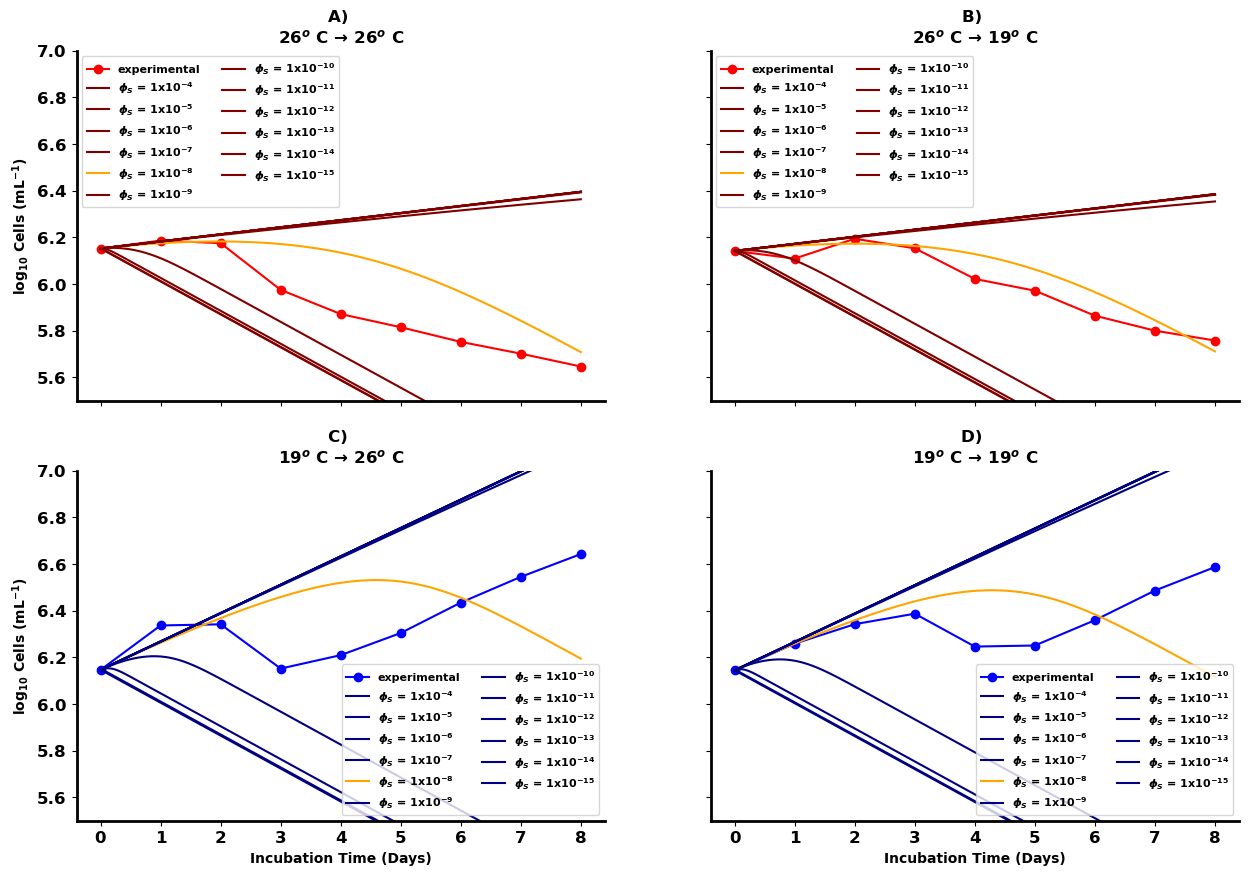

In [30]:
f,ax1 = plt.subplots(2,2,figsize=[15,10],sharex=True, sharey=True) # set up axes

ax1[0,0].set_title("A) \n"  "26$^{o}$ C \u2192 26$^{o}$ C",fontweight='bold')
ax1[0,0].set_ylabel('log$_{10}$ Cells (mL$^{-1}$)',fontweight='bold')
ax1[0,0].plot(Microcystis.Day, Microcystis.Host26a26_log10, 'red', marker='o',label='experimental') 
ax1[0,0].plot(t, Lhost26a26_ode[0], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-4}$')
ax1[0,0].plot(t, Lhost26a26_ode[1], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-5}$')
ax1[0,0].plot(t, Lhost26a26_ode[2], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-6}$')
ax1[0,0].plot(t, Lhost26a26_ode[3], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-7}$')
ax1[0,0].plot(t, Lhost26a26_ode[4], 'orange', label='$\phi$$_{S}$ = 1x10$^{-8}$') #Best Fit Lytic population Model
ax1[0,0].plot(t, Lhost26a26_ode[5], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-9}$')
ax1[0,0].plot(t, Lhost26a26_ode[6], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-10}$')
ax1[0,0].plot(t, Lhost26a26_ode[7], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-11}$')
ax1[0,0].plot(t, Lhost26a26_ode[8], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-12}$')
ax1[0,0].plot(t, Lhost26a26_ode[9], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-13}$')
ax1[0,0].plot(t, Lhost26a26_ode[10], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-14}$')
ax1[0,0].plot(t, Lhost26a26_ode[11], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-15}$')
ax1[0,0].set_ylim([5.5, 7])

ax1[0,1].set_title("B) \n" "26$^{o}$ C \u2192 19$^{o}$ C",fontweight='bold')
ax1[0,1].plot(Microcystis.Day, Microcystis.Host26a19_log10, 'red', marker='o',label='experimental')  #Resistant Subpopulation Model
ax1[0,1].plot(t, Lhost26a19_ode[0], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-4}$')
ax1[0,1].plot(t, Lhost26a19_ode[1], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-5}$')
ax1[0,1].plot(t, Lhost26a19_ode[2], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-6}$')
ax1[0,1].plot(t, Lhost26a19_ode[3], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-7}$')
ax1[0,1].plot(t, Lhost26a19_ode[4], 'orange', label='$\phi$$_{S}$ = 1x10$^{-8}$') #Best Fit Lytic population Model
ax1[0,1].plot(t, Lhost26a19_ode[5], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-9}$')
ax1[0,1].plot(t, Lhost26a19_ode[6], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-10}$')
ax1[0,1].plot(t, Lhost26a19_ode[7], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-11}$')
ax1[0,1].plot(t, Lhost26a19_ode[8], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-12}$')
ax1[0,1].plot(t, Lhost26a19_ode[9], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-13}$')
ax1[0,1].plot(t, Lhost26a19_ode[10], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-14}$')
ax1[0,1].plot(t, Lhost26a19_ode[11], 'maroon', label='$\phi$$_{S}$ = 1x10$^{-15}$')
ax1[0,1].set_ylim([5.5, 7])

ax1[1,0].set_title("C) \n" "19$^{o}$ C \u2192 26$^{o}$ C",fontweight='bold')
ax1[1,0].set_ylabel('log$_{10}$ Cells (mL$^{-1}$)',fontweight='bold')
ax1[1,0].set_xlabel("Incubation Time (Days)",fontweight='bold')
ax1[1,0].plot(Microcystis.Day, Microcystis.Host19a26_log10, 'blue', marker='o',label='experimental')  #Resistant Subpopulation Model
ax1[1,0].plot(t, Lhost19a26_ode[0], 'navy', label='$\phi$$_{S}$ = 1x10$^{-4}$')
ax1[1,0].plot(t, Lhost19a26_ode[1], 'navy', label='$\phi$$_{S}$ = 1x10$^{-5}$')
ax1[1,0].plot(t, Lhost19a26_ode[2], 'navy', label='$\phi$$_{S}$ = 1x10$^{-6}$')
ax1[1,0].plot(t, Lhost19a26_ode[3], 'navy', label='$\phi$$_{S}$ = 1x10$^{-7}$')
ax1[1,0].plot(t, Lhost19a26_ode[4], 'orange', label='$\phi$$_{S}$ = 1x10$^{-8}$') #Best Fit Lytic population Model
ax1[1,0].plot(t, Lhost19a26_ode[5], 'navy', label='$\phi$$_{S}$ = 1x10$^{-9}$')
ax1[1,0].plot(t, Lhost19a26_ode[6], 'navy', label='$\phi$$_{S}$ = 1x10$^{-10}$')
ax1[1,0].plot(t, Lhost19a26_ode[7], 'navy', label='$\phi$$_{S}$ = 1x10$^{-11}$')
ax1[1,0].plot(t, Lhost19a26_ode[8], 'navy', label='$\phi$$_{S}$ = 1x10$^{-12}$')
ax1[1,0].plot(t, Lhost19a26_ode[9], 'navy', label='$\phi$$_{S}$ = 1x10$^{-13}$')
ax1[1,0].plot(t, Lhost19a26_ode[10], 'navy', label='$\phi$$_{S}$ = 1x10$^{-14}$')
ax1[1,0].plot(t, Lhost19a26_ode[11], 'navy', label='$\phi$$_{S}$ = 1x10$^{-15}$')
ax1[1,0].set_ylim([5.5, 7])

ax1[1,1].set_title("D) \n" "19$^{o}$ C \u2192 19$^{o}$ C",fontweight='bold')
ax1[1,1].set_xlabel("Incubation Time (Days)",fontweight='bold')
ax1[1,1].plot(Microcystis.Day, Microcystis.Host19a19_log10, 'blue', marker='o',label='experimental') 
ax1[1,1].plot(t, Lhost19a19_ode[0], 'navy', label='$\phi$$_{S}$ = 1x10$^{-4}$')
ax1[1,1].plot(t, Lhost19a19_ode[1], 'navy', label='$\phi$$_{S}$ = 1x10$^{-5}$')
ax1[1,1].plot(t, Lhost19a19_ode[2], 'navy', label='$\phi$$_{S}$ = 1x10$^{-6}$')
ax1[1,1].plot(t, Lhost19a19_ode[3], 'navy', label='$\phi$$_{S}$ = 1x10$^{-7}$')
ax1[1,1].plot(t, Lhost19a19_ode[4], 'orange', label='$\phi$$_{S}$ = 1x10$^{-8}$') #Best Fit Lytic population Model
ax1[1,1].plot(t, Lhost19a19_ode[5], 'navy', label='$\phi$$_{S}$ = 1x10$^{-9}$')
ax1[1,1].plot(t, Lhost19a19_ode[6], 'navy', label='$\phi$$_{S}$ = 1x10$^{-10}$')
ax1[1,1].plot(t, Lhost19a19_ode[7], 'navy', label='$\phi$$_{S}$ = 1x10$^{-11}$')
ax1[1,1].plot(t, Lhost19a19_ode[8], 'navy', label='$\phi$$_{S}$ = 1x10$^{-12}$')
ax1[1,1].plot(t, Lhost19a19_ode[9], 'navy', label='$\phi$$_{S}$ = 1x10$^{-13}$')
ax1[1,1].plot(t, Lhost19a19_ode[10], 'navy', label='$\phi$$_{S}$ = 1x10$^{-14}$')
ax1[1,1].plot(t, Lhost19a19_ode[11], 'navy', label='$\phi$$_{S}$ = 1x10$^{-15}$')
ax1[1,1].set_ylim([5.5, 7])

for ax in ax1.flat:
    ax.legend(loc='best',fontsize=8,ncol=2)
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
fontproperties = {'family':'Arial'}
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.show()
f.savefig('sf3.png')

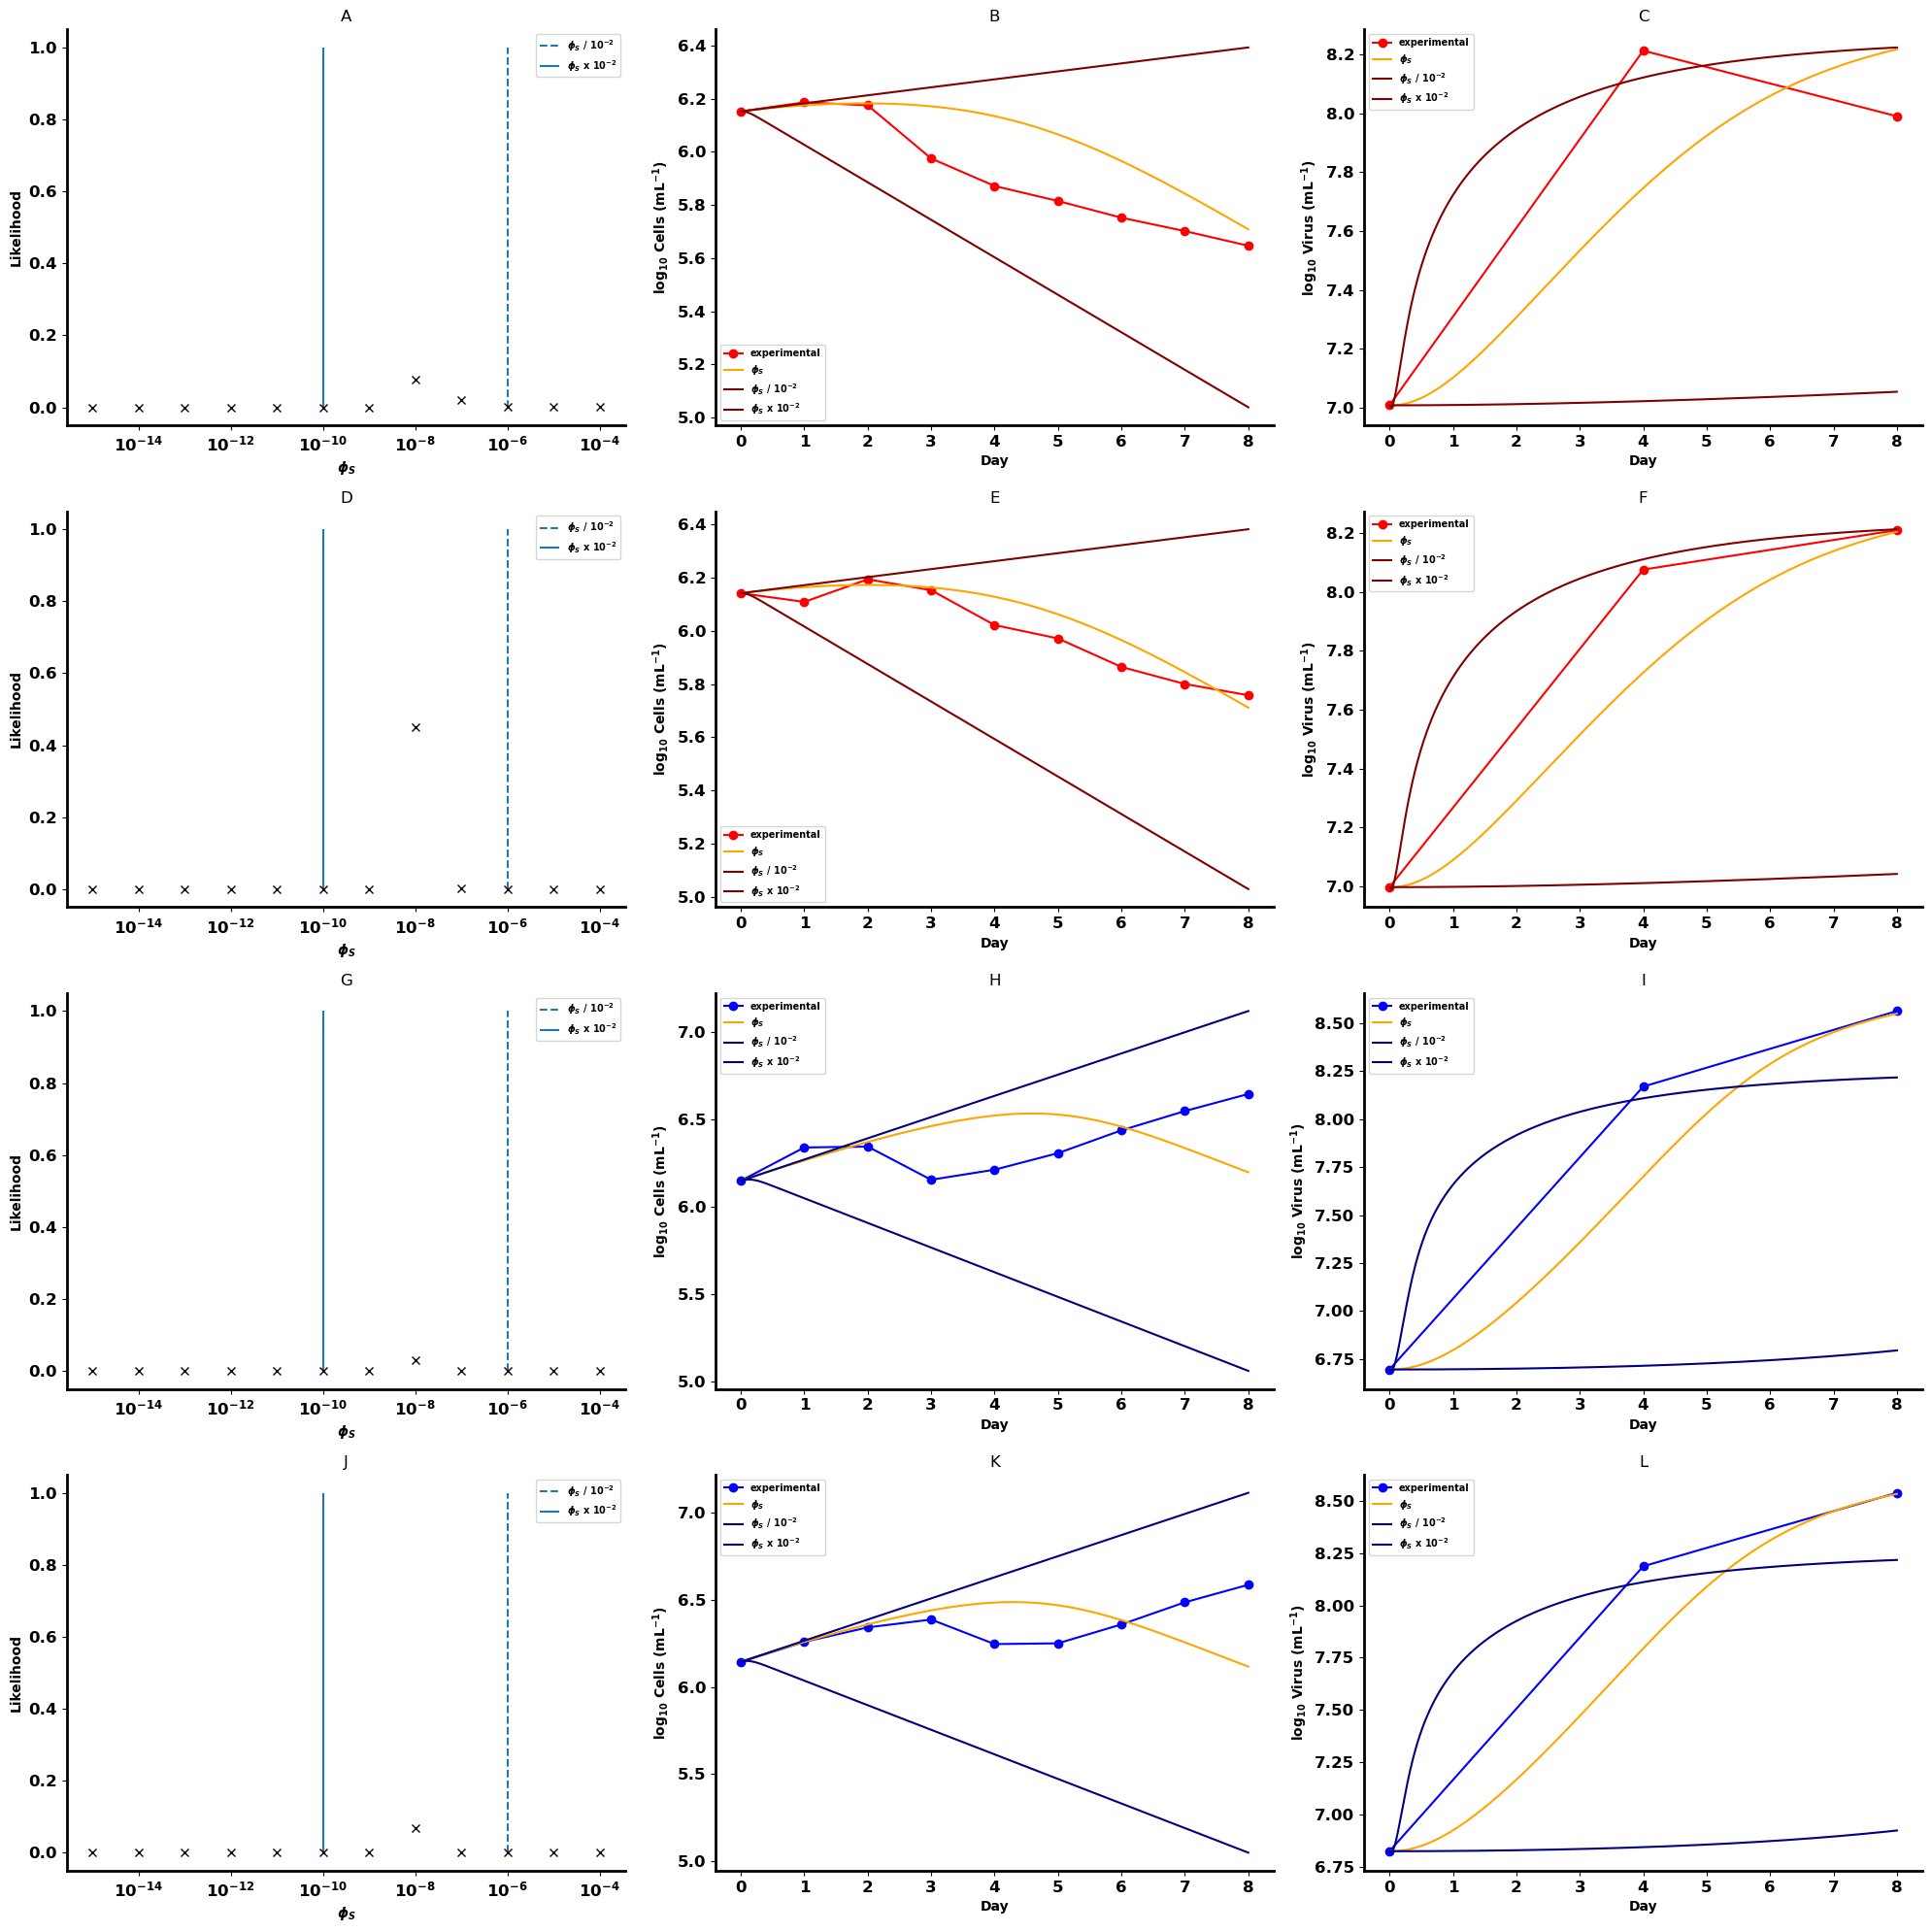

In [17]:
f,ax = plt.subplots(4,3,figsize=[20,20]) # set up axes

#26a26 - panel A
ax[0,0].set_title("A")
ax[0,0].set(xlabel='$\phi$$_{S}$', ylabel='Likelihood')
ax[0,0].vlines(x=1e-6, ymin=0,ymax=1,ls='--', label='$\phi$$_{S}$ / 10$^{-2}$')
ax[0,0].vlines(x=1e-10,ymin=0,ymax=1, label='$\phi$$_{S}$ x 10$^{-2}$')
#26a26 - panel B
ax[0,1].set_title("B")
ax[0,1].set(xlabel='Day', ylabel='log$_{10}$ Cells (mL$^{-1}$)')
ax[0,1].plot(Microcystis.Day, Microcystis.Host26a26_log10, 'red', marker='o',label='experimental')
ax[0,1].plot(t, Lhost26a26_ode[4], 'orange', label='$\phi$$_{S}$ ') #best
ax[0,1].plot(t, Lhost26a26_ode[2], 'maroon', label='$\phi$$_{S}$ / 10$^{-2}$') 
ax[0,1].plot(t, Lhost26a26_ode[6], 'maroon', label='$\phi$$_{S}$ x 10$^{-2}$') 
#26a26 - panel C
ax[0,2].set_title("C")
ax[0,2].set(xlabel='Day', ylabel='log$_{10}$ Virus (mL$^{-1}$)')
ax[0,2].plot(VLP.Day, VLP.VLP26a26_log10, 'red', marker='o',label='experimental')
ax[0,2].plot(t, LVLP26a26_ode[4], 'orange', label='$\phi$$_{S}$ ') #best
ax[0,2].plot(t, LVLP26a26_ode[2], 'maroon', label='$\phi$$_{S}$ / 10$^{-2}$') 
ax[0,2].plot(t, LVLP26a26_ode[6], 'maroon', label='$\phi$$_{S}$ x 10$^{-2}$') 


#26a19 - panel D
ax[1,0].set_title("D")
ax[1,0].set(xlabel='$\phi$$_{S}$', ylabel='Likelihood')
ax[1,0].vlines(x=1e-6, ymin=0,ymax=1,ls='--', label='$\phi$$_{S}$ / 10$^{-2}$')
ax[1,0].vlines(x=1e-10,ymin=0,ymax=1, label='$\phi$$_{S}$ x 10$^{-2}$')
#26a19 - panel E
ax[1,1].set_title("E")
ax[1,1].set(xlabel='Day', ylabel='log$_{10}$ Cells (mL$^{-1}$)')
ax[1,1].plot(Microcystis.Day, Microcystis.Host26a19_log10, 'red', marker='o',label='experimental')
ax[1,1].plot(t, Lhost26a19_ode[4], 'orange', label='$\phi$$_{S}$ ') #best 
ax[1,1].plot(t, Lhost26a19_ode[2], 'maroon', label='$\phi$$_{S}$ / 10$^{-2}$') 
ax[1,1].plot(t, Lhost26a19_ode[6], 'maroon', label='$\phi$$_{S}$ x 10$^{-2}$') 
#26a19 - panel F
ax[1,2].set_title("F")
ax[1,2].set(xlabel='Day', ylabel='log$_{10}$ Virus (mL$^{-1}$)')
ax[1,2].plot(VLP.Day, VLP.VLP26a19_log10, 'red', marker='o',label='experimental')
ax[1,2].plot(t, LVLP26a19_ode[4], 'orange', label='$\phi$$_{S}$ ') #best
ax[1,2].plot(t, LVLP26a19_ode[2], 'maroon', label='$\phi$$_{S}$ / 10$^{-2}$') 
ax[1,2].plot(t, LVLP26a19_ode[6], 'maroon', label='$\phi$$_{S}$ x 10$^{-2}$') 

#19a26 - panel G
ax[2,0].set_title("G")
ax[2,0].set(xlabel='$\phi$$_{S}$', ylabel='Likelihood')
ax[2,0].vlines(x=1e-6, ymin=0,ymax=1,ls='--', label='$\phi$$_{S}$ / 10$^{-2}$')
ax[2,0].vlines(x=1e-10,ymin=0,ymax=1, label='$\phi$$_{S}$ x 10$^{-2}$')
#19a26 - panel H
ax[2,1].set_title("H")
ax[2,1].set(xlabel='Day', ylabel='log$_{10}$ Cells (mL$^{-1}$)')
ax[2,1].plot(Microcystis.Day, Microcystis.Host19a26_log10, 'blue', marker='o',label='experimental')
ax[2,1].plot(t, Lhost19a26_ode[4], 'orange', label='$\phi$$_{S}$ ')  #best
ax[2,1].plot(t, Lhost19a26_ode[2], 'navy', label='$\phi$$_{S}$ / 10$^{-2}$') 
ax[2,1].plot(t, Lhost19a26_ode[6], 'navy', label='$\phi$$_{S}$ x 10$^{-2}$') 
#19a26 - panel I
ax[2,2].set_title("I")
ax[2,2].set(xlabel='Day', ylabel='log$_{10}$ Virus (mL$^{-1}$)')
ax[2,2].plot(VLP.Day, VLP.VLP19a26_log10, 'blue', marker='o',label='experimental')
ax[2,2].plot(t, LVLP19a26_ode[4], 'orange', label='$\phi$$_{S}$ ') #best
ax[2,2].plot(t, LVLP19a26_ode[2], 'navy', label='$\phi$$_{S}$ / 10$^{-2}$') 
ax[2,2].plot(t, LVLP19a26_ode[6], 'navy', label='$\phi$$_{S}$ x 10$^{-2}$') 

#19a19 - panel J
ax[3,0].set_title("J")
ax[3,0].set(xlabel='$\phi$$_{S}$', ylabel='Likelihood')
ax[3,0].vlines(x=1e-6, ymin=0,ymax=1,ls='--', label='$\phi$$_{S}$ / 10$^{-2}$')
ax[3,0].vlines(x=1e-10,ymin=0,ymax=1, label='$\phi$$_{S}$ x 10$^{-2}$')
#19a19 - panel K
ax[3,1].set_title("K")
ax[3,1].set(xlabel='Day', ylabel='log$_{10}$ Cells (mL$^{-1}$)')
ax[3,1].plot(Microcystis.Day, Microcystis.Host19a19_log10, 'blue', marker='o',label='experimental')
ax[3,1].plot(t, Lhost19a19_ode[4], 'orange', label='$\phi$$_{S}$ ') #best 
ax[3,1].plot(t, Lhost19a19_ode[2], 'navy', label='$\phi$$_{S}$ / 10$^{-2}$') 
ax[3,1].plot(t, Lhost19a19_ode[6], 'navy', label='$\phi$$_{S}$ x 10$^{-2}$') 
#19a19 - panel L
ax[3,2].set_title("L")
ax[3,2].set(xlabel='Day', ylabel='log$_{10}$ Virus (mL$^{-1}$)')
ax[3,2].plot(VLP.Day, VLP.VLP19a19_log10, 'blue', marker='o',label='experimental')
ax[3,2].plot(t, LVLP19a19_ode[4], 'orange', label='$\phi$$_{S}$ ') #best 
ax[3,2].plot(t, LVLP19a19_ode[2], 'navy', label='$\phi$$_{S}$ / 10$^{-2}$') 
ax[3,2].plot(t, LVLP19a19_ode[6], 'navy', label='$\phi$$_{S}$ x 10$^{-2}$') 

ax[0,0].set_xscale('log')
ax[1,0].set_xscale('log')
ax[2,0].set_xscale('log')
ax[3,0].set_xscale('log')

for i in phi_L:
    ax[0,0].plot(i,(variancesdf_26a26L)[str(i)],'black',marker='x') 
    ax[1,0].plot(i,(variancesdf_26a19L)[str(i)],'black',marker='x') 
    ax[2,0].plot(i,(variancesdf_19a26L)[str(i)],'black',marker='x')
    ax[3,0].plot(i,(variancesdf_19a19L)[str(i)],'black',marker='x')

for ax in ax.flat:
    ax.legend(loc='best',fontsize=7)
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
fontproperties = {'family':'Times New Roman'}
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"

plt.tight_layout()
plt.show()
f.savefig('sf3.png')